In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
import pint_pandas
from metpy import constants
from scipy import interpolate
np.set_printoptions(suppress=True,precision=10)

# Open SOS Measurement Dataset, extract measurements

In [2]:
start_date = '20221130'
end_date = '20230509'
# open files
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

## Add combined blowing snow flux variable
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue',
    'snow flux',
    1,
    'ue',
)

## Add absolute humidity measurements by converting hygrometer measurements

In [3]:
tower_height_keys = tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height']).indices.keys()
for t, h in tower_height_keys:
    this_tower_height_tidy_df = tidy_df.query(
            f"tower == '{t}'"
        ).query(
            f"height == {h}"
        )
    specific_humidity_values = this_tower_height_tidy_df.query(
            "measurement == 'specific humidity'"
        ).set_index('time')[['value']].rename(columns={'value': 'specific humidity'})
    air_density_values = this_tower_height_tidy_df.query(
            "measurement == 'air density'"
        ).set_index('time')[['value']].rename(columns={'value': 'air density'})
    combined_df = specific_humidity_values.join(air_density_values)

    abs_humidity_values = (
        combined_df['specific humidity'].values * units('g/g')
    ).to('g/kg') * (
        combined_df['air density'].values * units('kg/m^3')
    ).m

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        abs_humidity_values,
        f"absolutehumidity_{int(h)}m_{t}",
        'absolute humidity',
        int(h),
        t
    )

# Calibrate gas analyzer measurements

## Assume that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

In [4]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [5]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [6]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.128948,2.080217,0.048731
1,h2o_10m_d,d,10.0,1.264312,2.080217,-0.815905
2,h2o_10m_ue,ue,10.0,1.091568,2.080217,-0.988648
3,h2o_10m_uw,uw,10.0,1.608586,2.080217,-0.471630
4,h2o_15m_c,c,15.0,1.954592,2.065882,-0.111290
5,h2o_1m_d,d,1.0,1.700445,NaN,NaN
6,h2o_1m_ue,ue,1.0,1.310203,NaN,NaN
7,h2o_1m_uw,uw,1.0,1.502313,NaN,NaN
8,h2o_20m_c,c,20.0,0.934247,2.056363,-1.122116
9,h2o_2m_c,c,2.0,1.975427,2.116022,-0.140595


## Update dataset with corrections

In [7]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([3,10])]

alt.Chart(
    src[ src.time > '20221220' ][ src.time < '20221224' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/3782152281.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221220' ][ src.time < '20221224' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [8]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [9]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [10]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([3,10])]

alt.Chart(
    src[ src.time > '20221220' ][ src.time < '20221224' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/3782152281.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221220' ][ src.time < '20221224' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Create wide df

In [11]:
vars = [
    'dir_3m_ue', 'u_h2o__3m_ue', 'v_h2o__3m_ue', 'w_h2o__3m_ue',     'u_3m_ue',  'v_3m_ue',  'w_3m_ue', 
    'dir_10m_ue', 'u_h2o__10m_ue','v_h2o__10m_ue', 'w_h2o__10m_ue',   'u_10m_ue',  'v_10m_ue', 'w_10m_ue',
    
    'dir_3m_uw', 'u_h2o__3m_uw', 'v_h2o__3m_uw', 'w_h2o__3m_uw',     'u_3m_uw',  'v_3m_uw',  'w_3m_uw', 
    'dir_10m_uw', 'u_h2o__10m_uw','v_h2o__10m_uw', 'w_h2o__10m_uw',   'u_10m_uw',  'v_10m_uw', 'w_10m_uw',

    'dir_3m_d', 'u_h2o__3m_d', 'v_h2o__3m_d', 'w_h2o__3m_d',        'u_3m_d',   'v_3m_d',   'w_3m_d',  
    'dir_10m_d', 'u_h2o__10m_d','v_h2o__10m_d', 'w_h2o__10m_d',      'u_10m_d',  'v_10m_d',  'w_10m_d', 

    'dir_2m_c', 'u_h2o__2m_c', 'v_h2o__2m_c', 'w_h2o__2m_c',        'u_2m_c',   'v_2m_c',   'w_2m_c',   'specifichumidity_2m_c',    'airdensity_2m_c',
    'dir_3m_c', 'u_h2o__3m_c', 'v_h2o__3m_c', 'w_h2o__3m_c',        'u_3m_c',   'v_3m_c',   'w_3m_c',   'specifichumidity_3m_c',    'airdensity_3m_c',
    'dir_5m_c', 'u_h2o__5m_c', 'v_h2o__5m_c', 'w_h2o__5m_c',        'u_5m_c',   'v_5m_c',   'w_5m_c',   'specifichumidity_5m_c',    'airdensity_5m_c',
    'dir_10m_c', 'u_h2o__10m_c','v_h2o__10m_c', 'w_h2o__10m_c',      'u_10m_c',  'v_10m_c',  'w_10m_c',  'specifichumidity_10m_c',   'airdensity_10m_c',
    'dir_15m_c', 'u_h2o__15m_c', 'v_h2o__15m_c', 'w_h2o__15m_c',     'u_15m_c',  'v_15m_c',  'w_15m_c',  'specifichumidity_15m_c',   'airdensity_15m_c',
    'dir_20m_c', 'u_h2o__20m_c', 'v_h2o__20m_c', 'w_h2o__20m_c',     'u_20m_c',  'v_20m_c',  'w_20m_c',  'specifichumidity_20m_c',   'airdensity_20m_c',

    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c', 
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'Rsw_in_9m_d', 'Rnet_9m_d',

    'SF_avg_ue',

    'Ri_3m_c',

    'L_3m_c',
]

pivot_df = tidy_df[tidy_df.variable.isin(vars)][
    ['time', 'variable', 'value']
].pivot_table(index='time', columns='variable', values='value')

assert len(vars) == len(pivot_df.columns.unique())

In [12]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

# Create table with instrument location info 

We use a file with theodolite/GPS readings provided by NCAR. 

In [13]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/3668931392.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()


x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

# Create tables

## Wind field measurements

In [14]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin([3,10])]
wind_field_df = round(wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
wind_field_df.head()

height                 3.0                                                   \
tower                     c                       d                      ue   
measurement               u       v       w       u       v       w       u   
time                                                                          
2022-11-30 00:00:00  1.4759 -2.3654  0.0290  1.3250 -2.2228  0.0249  1.3299   
2022-11-30 00:30:00 -0.2161 -1.0528  0.0139 -0.1842 -1.0802  0.0098 -0.2960   
2022-11-30 01:00:00  0.5141 -1.1427  0.0183  0.5035 -1.1152  0.0269  0.4819   
2022-11-30 01:30:00  1.2030 -1.8313  0.0163  1.1385 -1.7164  0.0260  1.1454   
2022-11-30 02:00:00 -0.2209 -0.8936  0.0130 -0.2662 -0.9376  0.0187 -0.3226   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement               v       w       u  ...       w       u       v   
time                                         ...                           
2022-11-30 00:00:00 -2.2896  0.0174  0.9409  ...  0.0071  2.5216 -2.1892   
2022-11-30 00:30:00 -1.0823  0.0245 -0.3465  ...  0.0662 -0.0728 -0.8173   
2022-11-30 01:00:00 -1.1220  0.0111  0.2337  ...  0.0413  0.6077 -0.6620   
2022-11-30 01:30:00 -1.7238  0.0086  0.6532  ... -0.0000  1.8981 -1.5050   
2022-11-30 02:00:00 -0.9337  0.0333 -0.2915  ...  0.0720 -0.0230 -0.5847   

height                                                                       
tower                            ue                      uw                  
measurement               w       u       v       w       u       v       w  
time                                                                         
2022-11-30 00:00:00 -0.0065  2.2063 -2.3715  0.0769  1.9062 -2.7111  0.0450  
2022-11-30 00:30:00  0.0189 -0.2529 -0.7708  0.0644 -0.2268 -0.7774  0.0337  
2022-11-30 01:00:00  0.0028  0.4626 -0.7353  0.0591  0.4763 -0.8679  0.0254  
2022-11-30 01:30:00 -0.0322  1.7291 -1.6854  0.0319  1.4610 -2.0030 -0.0294  
2022-11-30 02:00:00  0.0230 -0.1798 -0.4796  0.0902 -0.0708 -0.5148  0.0122  

[5 rows x 24 columns]

## Turbulent water vapor flux measurements

In [15]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin([3,10])]
turb_flux_field_df = round(turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
turb_flux_field_df.head()

height                 3.0                                                   \
tower                     c                       d                      ue   
measurement          u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_   
time                                                                          
2022-11-30 00:00:00 -0.0177  0.0057  0.0002 -0.0072 -0.0431 -0.0006 -0.0038   
2022-11-30 00:30:00 -0.0201  0.0128  0.0001 -0.0206  0.0144 -0.0004 -0.0240   
2022-11-30 01:00:00  0.0022  0.0056  0.0003 -0.0023  0.0041 -0.0002 -0.0073   
2022-11-30 01:30:00 -0.0055  0.0003  0.0003 -0.0002  0.0004 -0.0003 -0.0063   
2022-11-30 02:00:00  0.0004  0.0206 -0.0002 -0.0028 -0.0160 -0.0006 -0.0064   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement          v_h2o_  w_h2o_  u_h2o_  ...  w_h2o_  u_h2o_  v_h2o_   
time                                         ...                           
2022-11-30 00:00:00 -0.0348 -0.0001 -0.0064  ...  0.0012 -0.0254  0.0075   
2022-11-30 00:30:00  0.0082 -0.0003 -0.0117  ...  0.0005 -0.0213  0.0102   
2022-11-30 01:00:00  0.0040 -0.0001 -0.0040  ... -0.0006 -0.0098  0.0011   
2022-11-30 01:30:00  0.0002 -0.0006 -0.0012  ...  0.0004 -0.0119  0.0032   
2022-11-30 02:00:00 -0.0208 -0.0019 -0.0020  ... -0.0003 -0.0088  0.0135   

height                                                                       
tower                            ue                      uw                  
measurement          w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  
time                                                                         
2022-11-30 00:00:00  0.0009 -0.0040  0.0051 -0.0003 -0.0298  0.0238  0.0001  
2022-11-30 00:30:00  0.0005 -0.0119  0.0123  0.0005 -0.0179  0.0177  0.0005  
2022-11-30 01:00:00 -0.0002 -0.0048  0.0034  0.0003 -0.0110  0.0028  0.0007  
2022-11-30 01:30:00  0.0006 -0.0108  0.0058 -0.0006 -0.0108  0.0062 -0.0002  
2022-11-30 02:00:00 -0.0004  0.0060  0.0244 -0.0002 -0.0002  0.0046 -0.0013  

[5 rows x 24 columns]

## Humidity measurements

In [16]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin([3,10])]
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

height                             3.0                       \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              1.2019              0.7553   
2022-11-30 00:30:00              1.3128              0.7867   
2022-11-30 01:00:00              1.3324              0.7876   
2022-11-30 01:30:00              1.3038              0.7969   
2022-11-30 02:00:00              1.3360              0.6982   
...                                 ...                 ...   
2023-05-09 15:30:00              2.4664              2.6617   
2023-05-09 16:00:00              2.4660              2.6428   
2023-05-09 16:30:00              2.6200              2.8197   
2023-05-09 17:00:00              2.5135              2.7082   
2023-05-09 17:30:00              2.7600              2.9733   

height                                                       \
tower                                ue                  uw   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              0.7909              0.8705   
2022-11-30 00:30:00              0.7596              0.9388   
2022-11-30 01:00:00              0.7876              0.9670   
2022-11-30 01:30:00              0.8061              0.9272   
2022-11-30 02:00:00              0.7069              0.9474   
...                                 ...                 ...   
2023-05-09 15:30:00              2.5909              2.7364   
2023-05-09 16:00:00              2.5880              2.7249   
2023-05-09 16:30:00              2.7385              2.9030   
2023-05-09 17:00:00              2.6553              2.7873   
2023-05-09 17:30:00              2.8969              3.0886   

height                             10.0                      \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-30 00:00:00              1.0104              0.9129   
2022-11-30 00:30:00              1.0503              0.9741   
2022-11-30 01:00:00              1.0805              1.0060   
2022-11-30 01:30:00              1.0612              0.9827   
2022-11-30 02:00:00              1.0986              1.0048   
...                                 ...                 ...   
2023-05-09 15:30:00              2.1723              2.4516   
2023-05-09 16:00:00              2.2089              2.4480   
2023-05-09 16:30:00              2.3425              2.5744   
2023-05-09 17:00:00              2.2988              2.4970   
2023-05-09 17:30:00              2.4174              2.6028   

height                                                       
tower                                ue                  uw  
measurement         Water vapor density Water vapor density  
time                                                         
2022-11-30 00:00:00              1.0040              1.0092  
2022-11-30 00:30:00              1.0798              1.1279  
2022-11-30 01:00:00              1.1239              1.1660  
2022-11-30 01:30:00              1.0905              1.1444  
2022-11-30 02:00:00              1.1193              1.1829  
...                                 ...                 ...  
2023-05-09 15:30:00              2.5774              2.2098  
2023-05-09 16:00:00              2.5768              2.2006  
2023-05-09 16:30:00              2.6768              2.3313  
2023-05-09 17:00:00              2.6286              2.2827  
2023-05-09 17:30:00              2.7749              2.4034  

[7425 rows x 8 columns]

## Advective flux measurements

In [17]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['u'] = this_wind_df['u']*this_abs_hum_df['Water vapor density']
        this_wind_df['v'] = this_wind_df['v']*this_abs_hum_df['Water vapor density']
        this_wind_df['w'] = this_wind_df['w']*this_abs_hum_df['Water vapor density']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new)

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df.head()

height                   3.0                                           \
tower                       c                             d             
measurement                 u         v         w         u         v   
time                                                                    
2022-11-30 00:00:00  1.773884 -2.842974  0.034855  1.000772 -1.678881   
2022-11-30 00:30:00 -0.283696 -1.382116  0.018248 -0.144910 -0.849793   
2022-11-30 01:00:00  0.684987 -1.522533  0.024383  0.396557 -0.878332   
2022-11-30 01:30:00  1.568471 -2.387649  0.021252  0.907271 -1.367799   
2022-11-30 02:00:00 -0.295122 -1.193850  0.017368 -0.185861 -0.654632   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                 w         u         v         w         u  ...   
time                                                                   ...   
2022-11-30 00:00:00  0.018807  1.051818 -1.810845  0.013762  0.819053  ...   
2022-11-30 00:30:00  0.007710 -0.224842 -0.822115  0.018610 -0.325294  ...   
2022-11-30 01:00:00  0.021186  0.379544 -0.883687  0.008742  0.225988  ...   
2022-11-30 01:30:00  0.020719  0.923307 -1.389555  0.006932  0.605647  ...   
2022-11-30 02:00:00  0.013056 -0.228046 -0.660033  0.023540 -0.276167  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                 w         u         v         w         u   
time                                                                    
2022-11-30 00:00:00  0.007174  2.301969 -1.998521 -0.005934  2.215125   
2022-11-30 00:30:00  0.069530 -0.070914 -0.796132  0.018410 -0.273081   
2022-11-30 01:00:00  0.044625  0.611346 -0.665972  0.002817  0.519916   
2022-11-30 01:30:00 -0.000000  1.865263 -1.478963 -0.031643  1.885584   
2022-11-30 02:00:00  0.079099 -0.023110 -0.587507  0.023110 -0.201250   

height                                                                 
tower                                          uw                      
measurement                 v         w         u         v         w  
time                                                                   
2022-11-30 00:00:00 -2.380986  0.077208  1.923737 -2.736042  0.045414  
2022-11-30 00:30:00 -0.832310  0.069539 -0.255808 -0.876829  0.038010  
2022-11-30 01:00:00 -0.826404  0.066422  0.555366 -1.011971  0.029616  
2022-11-30 01:30:00 -1.837929  0.034787  1.671968 -2.292233 -0.033645  
2022-11-30 02:00:00 -0.536816  0.100961 -0.083749 -0.608957  0.014431  

[5 rows x 24 columns]

# Create an interpolated wind field from measurements

## 2D example

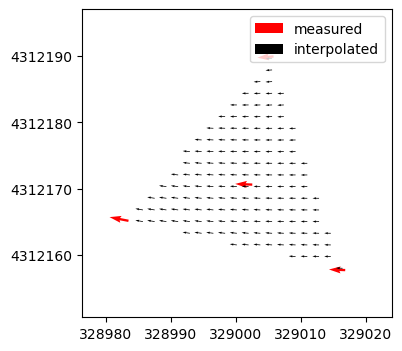

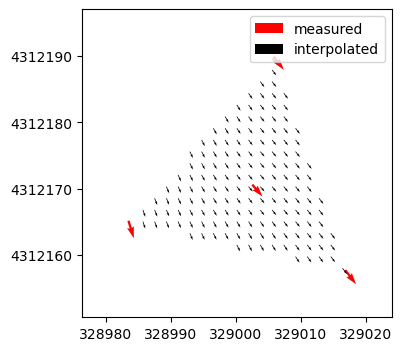

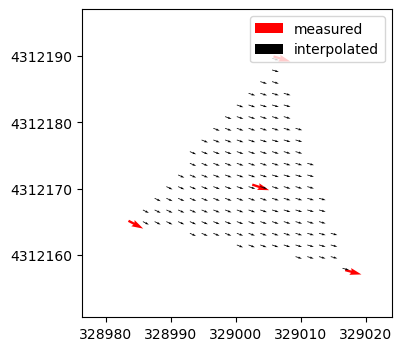

In [18]:
HEIGHT = 3
x = instrument_loc_df.loc[(HEIGHT)][['x']]
y = instrument_loc_df.loc[(HEIGHT)][['y']]
for i in [3000,3005,3050]:
    wind_field_vals = pd.DataFrame(wind_field_df.iloc[i][HEIGHT]).reset_index().set_index('tower').pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(wind_field_vals)
    xx = np.linspace(
        points_and_wind_fields.x.min()-5, 
        points_and_wind_fields.x.max()+5, 25
    )
    yy = np.linspace(
        points_and_wind_fields.y.min()-5, 
        points_and_wind_fields.y.max()+5, 25
    )
    xx, yy = np.meshgrid(xx, yy)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy), method='linear')

    # # we just have one density measurement at this height, so simply spread the
    # # measured density value across all the points
    # # rho_interp = np.full(u_interp.shape, src_3_c_density[i][0])

    fig, ax = plt.subplots(figsize=(4,4))
    ax.quiver(
        points_and_wind_fields.x, 
        points_and_wind_fields.y, 
        points_and_wind_fields.u, 
        points_and_wind_fields.v, 
        color='red', 
        label='measured'
    )
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.quiver(xx, yy, u_interp, v_interp, label='interpolated')
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.legend(loc='upper right')

## 3D example

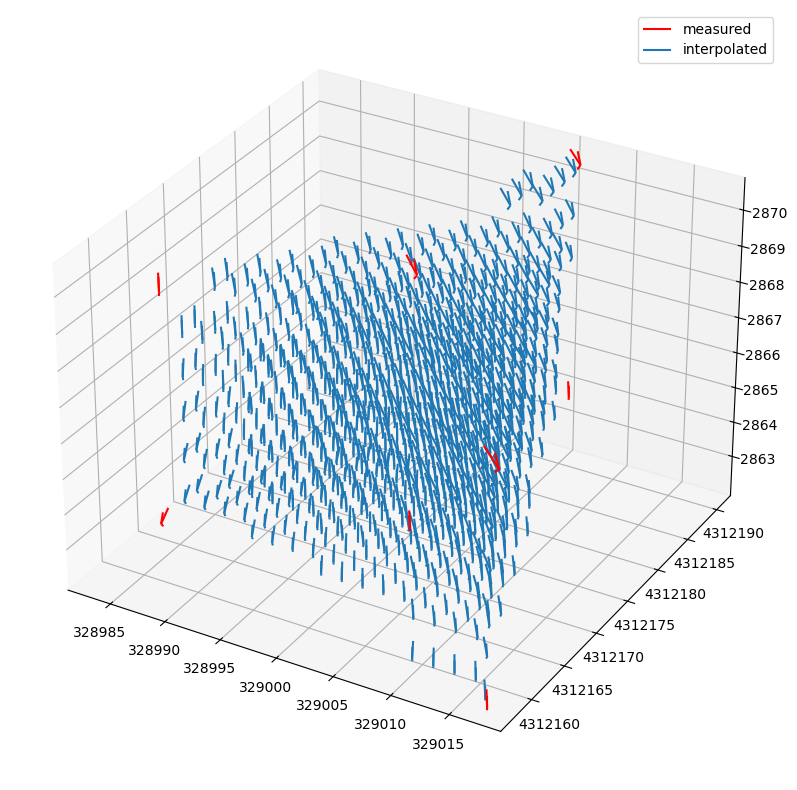

In [19]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

for i in [0]:
    wind_field_vals = pd.DataFrame(wind_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min()-5, 
        points_and_wind_fields.x.max()+5, 25
    )
    yy = np.linspace(
        points_and_wind_fields.y.min()-5, 
        points_and_wind_fields.y.max()+5, 25
    )
    zz = np.linspace(
        points_and_wind_fields.z.min()-1, 
        points_and_wind_fields.z.max()+1, 10
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
    ax.quiver(
        points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z, 
        points_and_wind_fields.u, points_and_wind_fields.v, points_and_wind_fields.w,
        color='red', label='measured', pivot='middle'
    )
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.quiver(xx, yy, zz, u_interp, v_interp, w_interp, label='interpolated', pivot='middle')
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.legend()

## 3D divergence calculations (volumetric)

In [20]:
def divergence(f,sp):
    """ Computes divergence of vector field 
    f: array -> vector field components [Fx,Fy,Fz,...]
    sp: array -> spacing between points in respecitve directions [spx, spy,spz,...]
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], sp[i], axis=i) for i in range(num_dims)])

In [21]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in range(0, wind_field_df.shape[0]):
    wind_field_vals = pd.DataFrame(wind_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min()-1, 
        points_and_wind_fields.x.max()+1, 25
    )
    yy = np.linspace(
        points_and_wind_fields.y.min()-1, 
        points_and_wind_fields.y.max()+1, 25
    )
    zz = np.linspace(
        points_and_wind_fields.z.min()-1, 
        points_and_wind_fields.z.max()+1, 10
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(wind_field_df) == len(mean_divergences)
windfield_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=wind_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/2100557506.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/2100557506.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/2100557506.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/2100557506.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/2100557506.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/2100557506.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.app

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/173837718.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/173837718.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence_lateral.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/173837718.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence_vertical.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


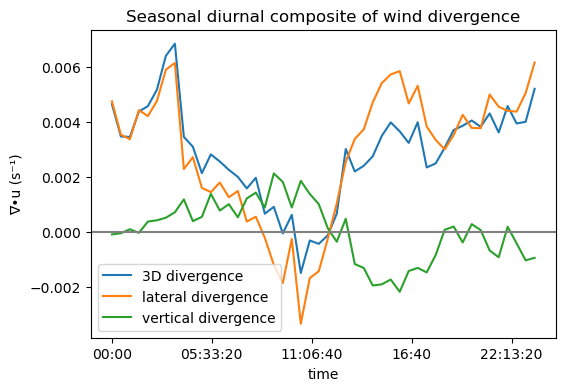

In [22]:
windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
windfield_div_df.mean_divergence_lateral.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
windfield_div_df.mean_divergence_vertical.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•u (s⁻¹)")
plt.title("Seasonal diurnal composite of wind divergence")
plt.legend()

<Axes: xlabel='time'>

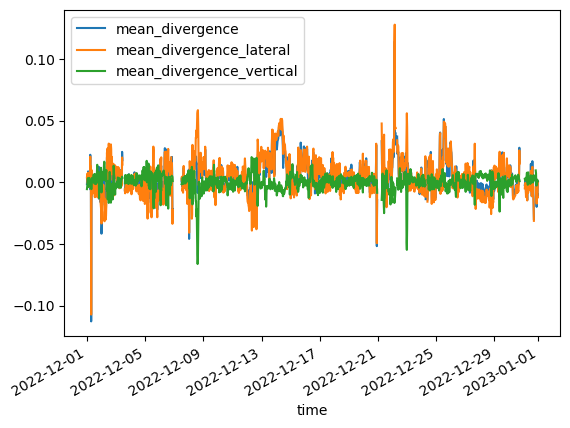

In [23]:
windfield_div_df.loc['20221201': '20221231'].plot()

## 3D divergence calculations (advected water vapor)

In [24]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in range(0, adv_flux_field_df.shape[0]):
    adv_flux_field_vals = pd.DataFrame(adv_flux_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    adv_flux_field_vals.columns = adv_flux_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(adv_flux_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min()-1, 
        points_and_wind_fields.x.max()+1, 25
    )
    yy = np.linspace(
        points_and_wind_fields.y.min()-1, 
        points_and_wind_fields.y.max()+1, 25
    )
    zz = np.linspace(
        points_and_wind_fields.z.min()-1, 
        points_and_wind_fields.z.max()+1, 10
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(adv_flux_field_df) == len(mean_divergences)
adv_flux_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=adv_flux_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/3182976858.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/3182976858.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/3182976858.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/3182976858.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/3182976858.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_18901/3182976858.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.app

In [ ]:
adv_flux_div_df.mean_divergence.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_df.mean_divergence_lateral.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_df.mean_divergence_vertical.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.legend()

## 3D divergence calculations (turb. diffused water vapor)

In [ ]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in range(0, turb_flux_field_df.shape[0]):
    turb_flux_field_vals = pd.DataFrame(turb_flux_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    turb_flux_field_vals.columns = turb_flux_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(turb_flux_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min()-1, 
        points_and_wind_fields.x.max()+1, 25
    )
    yy = np.linspace(
        points_and_wind_fields.y.min()-1, 
        points_and_wind_fields.y.max()+1, 25
    )
    zz = np.linspace(
        points_and_wind_fields.z.min()-1, 
        points_and_wind_fields.z.max()+1, 10
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u_h2o_, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v_h2o_, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w_h2o_, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(turb_flux_field_df) == len(mean_divergences)
turb_flux_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=turb_flux_field_df.index
)

In [ ]:
turb_flux_div_df.mean_divergence.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
turb_flux_div_df.mean_divergence_lateral.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
turb_flux_div_df.mean_divergence_vertical.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of turbulent flux divergence")
plt.legend()